<div class="usecase-title">Real-time parking hotspots</div>

<div class="usecase-authors"><b>Authored by: </b> Siju Deng</div>

<div class="usecase-duration"><b>Duration:</b> {90} mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>{Intermediate}</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>{Python, Machine  Learning / Data Wrangling}</div>
</div>

<div class="usecase-section-header">Scenario</div>

As an ordinary living in Melbourne. I want to avoid the difficulty of parking in the city.

*   Where is it difficult to park now?
*   Is it peak parking time now?

<div class="usecase-section-header">What this use case will teach you</div>

At the end of this use case you will:

*   Get to know the Melbourne city center parking map
*   Understand the current parking hotspots in  Melbourne city center
*   Learn about multi-file data filtering
*   Deepen understanding of snapshot data
*   Understand the necessity of data processing

<div class="usecase-section-header">Limitations and Purpose</div>

*   This notebook performs exploratory data analysis of Melbourne parking sensor data. Try combining Melbourne parking restriction data with Melbourne parking data. With exploratory analysis, attempts, and assumptions, it's not a rigorous conclusion.
*   Due to the snapshot nature of sensor data, the data within the notebook is a historical record of the time the notebook is running. This notebook can only be used as a reference and tutorial and does not have the function of real-time data. Please download and run if necessary. Limited by sensor failures and update issues. Data accuracy is not guaranteed.

# Get and process data

In [1]:
# from google.colab import drive
import os
import requests
import json
import pytz
import folium
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
from datetime import datetime, timezone
from pandas.tseries.offsets import Minute
from sklearn.cluster import DBSCAN

## Fetch Data from Open Data Melbourne

In [2]:
# drive.mount('/content/gdrive')

# with open('/content/gdrive/My Drive/Colab Notebooks/apiKey.txt', 'r') as file:
#     api_key = file.read().strip()

# api_key = os.getenv(api_key)

In [3]:
# export endpoint

# https://data.melbourne.vic.gov.au/explore/dataset/on-street-parking-bay-sensors/information/?dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJ5QXhpcyI6ImJheV9pZCIsInNjaWVudGlmaWNEaXNwbGF5Ijp0cnVlLCJjb2xvciI6IiNFNTBFNTYifV0sInhBeGlzIjoibGFzdHVwZGF0ZWQiLCJtYXhwb2ludHMiOjUwLCJzb3J0IjoiIiwidGltZXNjYWxlIjoieWVhciIsImNvbmZpZyI6eyJkYXRhc2V0Ijoib24tc3RyZWV0LXBhcmtpbmctYmF5LXNlbnNvcnMiLCJvcHRpb25zIjp7fX19XSwidGltZXNjYWxlIjoiIiwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D
dataset_id = 'on-street-parking-bay-sensors'

base_URL = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
# apikey = api_key
dataset_id = dataset_id
format = 'csv'

url = f'{base_URL}{dataset_id}/exports/{format}'
params = {
    'select': '*',
    'limit': -1,  # all records
    'lang': 'en',
    'timezone': 'UTC',
    # 'api_key': apikey
}

# GET request
response = requests.get(url, params = params)

if response.status_code == 200:
    # StringIO to read the CSV data
    url_content = response.content.decode('utf-8')
    df = pd.read_csv(StringIO(url_content), delimiter = ';')
    print(df.sample(2, random_state = 999))    # test
else:
    print(f'Request failed with status code {response.status_code}')

                    lastupdated           status_timestamp  zone_number  \
2278  2024-05-11T04:00:28+00:00  2024-05-10T07:07:30+00:00       7923.0   
1566  2024-04-30T04:44:26+00:00  2024-04-24T02:03:08+00:00       7828.0   

     status_description  kerbsideid                                location  
2278            Present       10827  -37.80718919017354, 144.95491544565937  
1566         Unoccupied       12887  -37.82918036666882, 144.96920419890168  


In [4]:
# check length in dataset
print(f'The dataset contains {len(df)} records.')

The dataset contains 6246 records.


## Data preprocessing

Separate latitude and longitude in data

In [5]:
print(df.dtypes)

lastupdated            object
status_timestamp       object
zone_number           float64
status_description     object
kerbsideid              int64
location               object
dtype: object


In [6]:
# Split the location string into latitude and longitude, then assign to new columns
df['latitude'] = df['location'].apply(lambda x: float(x.split(',')[0].strip()))
df['longitude'] = df['location'].apply(lambda x: float(x.split(',')[1].strip()))

# Drop the original location column
df.drop(columns = ['location'], inplace=True)

In [7]:
print(df.head(3))

                 lastupdated           status_timestamp  zone_number  \
0  2023-12-14T04:45:34+00:00  2023-12-14T03:41:25+00:00       7695.0   
1  2023-12-14T04:45:34+00:00  2023-12-13T06:21:58+00:00       7939.0   
2  2023-12-14T23:45:34+00:00  2023-12-14T23:35:02+00:00          NaN   

  status_description  kerbsideid   latitude   longitude  
0         Unoccupied       22959 -37.818448  144.959387  
1         Unoccupied       10136 -37.809991  144.952638  
2         Unoccupied        6527 -37.810601  144.956426  


Check null value and data type

In [8]:
def validate_data(df):
    print("\nChecking for NaN values:")
    print(df.isna().sum())
    print("\nChecking for Duplicates:")
    print(df.duplicated().sum())
    print("\nChecking data types:")
    print(df.dtypes)

validate_data(df)


Checking for NaN values:
lastupdated             0
status_timestamp        0
zone_number           487
status_description      0
kerbsideid              0
latitude                0
longitude               0
dtype: int64

Checking for Duplicates:
0

Checking data types:
lastupdated            object
status_timestamp       object
zone_number           float64
status_description     object
kerbsideid              int64
latitude              float64
longitude             float64
dtype: object


Since the zone number does not affect the geographical location coordinates and sensor ID, it is not processed. Check and eliminate abnormal time records below. Delete records older than one year.

In [9]:
# Define the function to convert columns to datetime
def convert_to_datetime(df, column_name):
    try:
        df[column_name] = pd.to_datetime(df[column_name], errors = 'coerce', format = "%Y-%m-%dT%H:%M:%S+00:00")
    except ValueError as e:
        print(f"Error converting {column_name}: {e}")

In [10]:
# Create a new DataFrame for analysis based on the original df
df_analysis = df.copy()

# Apply the datetime conversion function
convert_to_datetime(df_analysis, 'lastupdated')
convert_to_datetime(df_analysis, 'status_timestamp')

# Check for NaT values in datetime columns
nat_counts = df_analysis[['lastupdated', 'status_timestamp']].isna().sum()
print("NaT values after conversion:")
print(nat_counts)

NaT values after conversion:
lastupdated         0
status_timestamp    0
dtype: int64


In [11]:
# Identify the most recent timestamp
latest_timestamp = df_analysis['status_timestamp'].max()

# Calculate the date one year ago from the most recent timestamp
one_year_ago = latest_timestamp - pd.DateOffset(years=1)

# Filter and process as per your previous logic
outdated_rows = df_analysis[df_analysis['status_timestamp'] < one_year_ago].copy()

print("Outdated rows:")
print(outdated_rows.sort_values(by = 'status_timestamp').head())

# Print the data header sorted by 'status_timestamp'
print("\nData header sorted by time:")
print(df_analysis.sort_values(by = 'status_timestamp').head())

Outdated rows:
            lastupdated status_timestamp  zone_number status_description  \
618 2023-11-22 00:44:42       1970-01-01          NaN         Unoccupied   
101 2023-11-22 00:44:42       1970-01-01       7531.0         Unoccupied   
105 2023-11-22 00:44:42       1970-01-01       7531.0         Unoccupied   
131 2023-11-22 00:44:42       1970-01-01          NaN         Unoccupied   
688 2023-12-11 23:45:34       1970-01-01       7498.0         Unoccupied   

     kerbsideid   latitude   longitude  
618        6246 -37.817832  144.958757  
101        8027 -37.817671  144.955279  
105        8033 -37.817782  144.954895  
131        8040 -37.818000  144.954134  
688        7740 -37.812619  144.953622  

Data header sorted by time:
            lastupdated status_timestamp  zone_number status_description  \
101 2023-11-22 00:44:42       1970-01-01       7531.0         Unoccupied   
618 2023-11-22 00:44:42       1970-01-01          NaN         Unoccupied   
105 2023-11-22 00:44:42  

In [12]:
# Delete outdated rows
df_analysis = df_analysis[df_analysis['status_timestamp'] >= one_year_ago]

In [13]:
df_analysis.shape

(6154, 7)

Based on geographical location coordinates and parking space status and id. Check for duplicate information and eliminate it. Since the retrieval adopts a circular application, duplicate data may be obtained. This step cannot be omitted.

In [14]:
# Detect duplicates based on all columns
duplicates = df_analysis.duplicated(
    subset = ['kerbsideid', 'status_description', 'latitude', 'longitude'],
    keep = False)

# Display duplicates
print("Duplicate Rows based on all columns are:")
print(df_analysis[duplicates].sort_values('kerbsideid'))

Duplicate Rows based on all columns are:
Empty DataFrame
Columns: [lastupdated, status_timestamp, zone_number, status_description, kerbsideid, latitude, longitude]
Index: []


In [15]:
# Remove duplicates based on specified columns in df_analysis
df_analysis.drop_duplicates(
    subset = ['kerbsideid', 'status_description',
              'latitude', 'longitude', 'lastupdated'],
    keep = 'first', inplace = True)

# Data analysis

## Processing

Get the total number of data

In [16]:
# Drop duplicate rows based on 'latitude' and 'longitude'
unique_locations = df_analysis.drop_duplicates(subset = ['latitude', 'longitude'])

# Count the number of unique parking spaces based on location
total_unique_parking_spaces = len(unique_locations)

print(f"The total number of unique parking spaces based on location is {total_unique_parking_spaces}.")

The total number of unique parking spaces based on location is 5800.


Get parking spaces with non-single parking status, based on geographical location.

In [17]:
# Group by latitude and longitude and count occurrences in df_analysis
location_counts = df_analysis.groupby(
    ['latitude', 'longitude']).size().reset_index(name = 'Occurrences')

# Identify locations that appear more than once in df_analysis
duplicate_locations = location_counts[location_counts['Occurrences'] > 1]

# Print out the duplicate locations in df_analysis
if duplicate_locations.empty:
    print("Each geographic location occurs only once.")
else:
    print("Duplicate geographic locations found:")
    print(duplicate_locations)

Duplicate geographic locations found:
       latitude   longitude  Occurrences
1031 -37.819612  144.954532            2
1046 -37.819562  144.954509            2
1058 -37.819512  144.954486            2
1066 -37.819463  144.954464            2
1133 -37.819000  144.958300            2
...         ...         ...          ...
3862 -37.809577  144.971496            2
3868 -37.809559  144.971561            2
3869 -37.809551  144.971585            2
3871 -37.809544  144.971611            2
3874 -37.809536  144.971637            2

[353 rows x 3 columns]


Get geolocation with multiple kerbsideid

In [18]:
# Filter rows in df_analysis where geographic locations are duplicated
duplicate_locations = df_analysis[
    df_analysis.duplicated(subset = ['latitude', 'longitude'], keep = False)]

# Sort these rows in df_analysis by latitude, longitude, and kerbsideid for easier inspection
sorted_duplicates = duplicate_locations.sort_values(
    by = ['latitude', 'longitude', 'kerbsideid'])

# Print kerbsideid for duplicate locations in df_analysis
print("Kerbside id for duplicate locations:")
print(sorted_duplicates[['latitude', 'longitude', 'kerbsideid']])

Kerbside id for duplicate locations:
       latitude   longitude  kerbsideid
247  -37.819612  144.954532        8057
2065 -37.819612  144.954532       57924
722  -37.819562  144.954509        8056
4946 -37.819562  144.954509       57925
274  -37.819512  144.954486        8055
...         ...         ...         ...
1963 -37.809551  144.971585       65038
88   -37.809544  144.971611        6086
1964 -37.809544  144.971611       65037
206  -37.809536  144.971637        6087
1965 -37.809536  144.971637       65036

[707 rows x 3 columns]


Check if there are duplicate kerbsideid

In [19]:
# df_analysis is DataFrame for analysis
duplicate_kerbsideid = df_analysis[df_analysis['kerbsideid'].duplicated(keep = False)]

# Sort the data in df_analysis for easier inspection
duplicate_kerbsideids = duplicate_kerbsideid.sort_values('kerbsideid')

if len(duplicate_kerbsideid) > 0:
    print("Duplicate kerbsideid found in df_analysis:")
    print(duplicate_kerbsideid[['kerbsideid', 'latitude', 'longitude']])
else:
    print("No duplicate kerbsideid found in df_analysis.")

No duplicate kerbsideid found in df_analysis.


Explore the earliest time each parking space is empty

In [20]:
# Filter for 'Unoccupied' status in df_analysis
unoccupied_spaces = df_analysis[df_analysis['status_description'] == 'Unoccupied']

# Sort by 'status_timestamp' in df_analysis
sorted_unoccupied = unoccupied_spaces.sort_values(by = 'status_timestamp')

# Find the earliest time for each unique parking space based on latitude and longitude in df_analysis
earliest_unoccupied = sorted_unoccupied.drop_duplicates(
    subset = ['latitude', 'longitude'], keep = 'first')

# Display the result
print("The earliest time each parking space was detected as empty in df_analysis:")
print(earliest_unoccupied[['latitude', 'longitude', 'status_timestamp']])

The earliest time each parking space was detected as empty in df_analysis:
       latitude   longitude    status_timestamp
3744 -37.806193  144.952080 2023-05-27 16:40:41
2309 -37.806147  144.952089 2023-06-04 06:46:46
3743 -37.806170  144.952085 2023-06-05 07:35:13
2306 -37.806027  144.952110 2023-06-07 00:41:04
5187 -37.805884  144.952136 2023-06-07 01:13:53
...         ...         ...                 ...
2462 -37.845080  144.979728 2024-05-11 03:58:52
3038 -37.802832  144.967545 2024-05-11 03:58:52
4236 -37.803259  144.963037 2024-05-11 03:58:55
4889 -37.808623  144.960684 2024-05-11 03:58:55
4685 -37.809243  144.968867 2024-05-11 03:58:58

[1836 rows x 3 columns]


Check whether the occupied parking space has previously reported a vacant status.

In [21]:
# Convert to datetime format
df_analysis['lastupdated'] = pd.to_datetime(df_analysis['lastupdated'])
df_analysis['status_timestamp'] = pd.to_datetime(df_analysis['status_timestamp'])

# Sort and filter
sorted_df = df_analysis.sort_values(by = ['latitude', 'longitude', 'status_timestamp'])
current_vacant = sorted_df[sorted_df['status_description'] == 'Unoccupied'].copy()

# Initialize result DataFrame
result = pd.DataFrame(columns = ['latitude', 'longitude', 'last_occupied_time'])

# Loop through each vacant space to check its history
for idx, row in current_vacant.iterrows():
    lat, lon, current_time = row['latitude'], row['longitude'], row['status_timestamp']
    time_threshold = current_time - pd.Timedelta(hours = 3)
    previous_records = sorted_df[
        (sorted_df['latitude'] == lat) &
         (sorted_df['longitude'] == lon) &
          (sorted_df['status_timestamp'] >= time_threshold) &
           (sorted_df['status_description'] == 'Present')]

    if not previous_records.empty:
        last_occupied_time = previous_records['status_timestamp'].max()
        new_row = pd.DataFrame(
            {'latitude': [lat], 'longitude': [lon],
             'last_occupied_time': [last_occupied_time]})
        result = pd.concat([result, new_row], ignore_index = True)

# Display the result
print("Parking spaces that were occupied a few hours ago and are now vacant:")
print(result)

/var/folders/47/cww9rckj6d77h_cvkkhbkvzw0000gn/T/ipykernel_78532/2537725324.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, new_row], ignore_index = True)


Parking spaces that were occupied a few hours ago and are now vacant:
     latitude   longitude  last_occupied_time
0  -37.818448  144.959387 2024-03-13 03:03:31
1  -37.818156  144.957058 2024-05-11 01:52:59
2  -37.818018  144.954073 2024-05-10 20:33:28
3  -37.817982  144.954198 2024-04-03 22:49:13
4  -37.817890  144.958554 2024-05-11 02:09:09
..        ...         ...                 ...
65 -37.809787  144.972304 2024-05-11 03:06:17
66 -37.809781  144.970468 2024-05-11 03:45:25
67 -37.809599  144.971422 2024-05-11 03:06:00
68 -37.809577  144.971496 2024-05-11 02:18:32
69 -37.809544  144.971611 2024-05-11 00:56:13

[70 rows x 3 columns]


## Analyze results

* It can be found that very few sensors report both statuses. At the same time, some sensors have two parking space ids. Each parking space ID has only one status, and there are no duplicate IDs. It may be due to the nature of the sensor. Because the geographical location is the sensor location, sometimes one sensor can manage two parking spaces.

* It can be determined that this data set is snapshot attribute data. When a sensor reports a state change, the old state is deleted from the data. Also, referring to the official documentation, each sensor will be tested every morning. Today's data is the only reliable data. Other sensors cannot be used due to construction closures and other reasons.

# Data processing

Convert time zone from UTC to Melbourne time

In [22]:
# Create a timezone object for Melbourne
melbourne_tz = pytz.timezone('Australia/Melbourne')

# Get the current time in UTC
current_time_utc = datetime.now(pytz.utc)

# Convert to Melbourne local time
current_time_melbourne = current_time_utc.astimezone(melbourne_tz)

print(f"Current time in UTC: {current_time_utc}")
print(f"Current time in Melbourne: {current_time_melbourne}")

Current time in UTC: 2024-05-11 04:01:42.785667+00:00
Current time in Melbourne: 2024-05-11 14:01:42.785667+10:00


In [23]:
# Check if 'status_timestamp' is timezone-naive
if df_analysis['status_timestamp'].dt.tz is None:
    # Localize naive datetime objects to UTC
    df_analysis['status_timestamp'] = df_analysis['status_timestamp'].dt.tz_localize('UTC')
else:
    # If already timezone-aware, ensure it's in UTC
    df_analysis['status_timestamp'] = df_analysis['status_timestamp'].dt.tz_convert('UTC')

# Convert 'status_timestamp' from UTC to Melbourne local time
df_analysis['status_timestamp'] = df_analysis['status_timestamp'].dt.tz_convert('Australia/Melbourne')

# Display the first few 'status_timestamp' to check
print(df_analysis['status_timestamp'].head())

0   2023-12-14 14:41:25+11:00
1   2023-12-13 17:21:58+11:00
2   2023-12-15 10:35:02+11:00
3   2023-12-15 09:39:46+11:00
4   2023-12-18 10:47:54+11:00
Name: status_timestamp, dtype: datetime64[ns, Australia/Melbourne]


Get today’s data volume

In [24]:
print("Unique dates in the dataset:", df_analysis['status_timestamp'].dt.date.unique())

# Get today's date from the 'current_time_melbourne' which is already timezone-aware
today_melbourne = current_time_melbourne.date()
print("Today's date in Melbourne:", today_melbourne)

# Convert 'status_timestamp' to date only for filtering
df_analysis['status_date'] = df_analysis['status_timestamp'].dt.date

# Filter for today's data
todays_data = df_analysis[df_analysis['status_date'] == today_melbourne]

# Count the number of rows in today's data
num_rows_today = len(todays_data)
print(f"There are {num_rows_today} rows in today's data.")

Unique dates in the dataset: [datetime.date(2023, 12, 14) datetime.date(2023, 12, 13)
 datetime.date(2023, 12, 15) datetime.date(2023, 12, 18)
 datetime.date(2023, 11, 2) datetime.date(2023, 11, 15)
 datetime.date(2023, 11, 8) datetime.date(2023, 11, 9)
 datetime.date(2023, 12, 6) datetime.date(2023, 12, 7)
 datetime.date(2023, 12, 4) datetime.date(2023, 9, 6)
 datetime.date(2023, 8, 11) datetime.date(2023, 10, 25)
 datetime.date(2023, 10, 24) datetime.date(2023, 10, 18)
 datetime.date(2023, 9, 27) datetime.date(2023, 6, 12)
 datetime.date(2023, 9, 7) datetime.date(2023, 11, 22)
 datetime.date(2023, 11, 21) datetime.date(2023, 11, 16)
 datetime.date(2023, 6, 20) datetime.date(2023, 11, 17)
 datetime.date(2023, 11, 20) datetime.date(2023, 11, 13)
 datetime.date(2023, 11, 11) datetime.date(2023, 11, 14)
 datetime.date(2023, 8, 12) datetime.date(2023, 10, 27)
 datetime.date(2023, 12, 5) datetime.date(2023, 11, 3)
 datetime.date(2023, 11, 1) datetime.date(2023, 11, 26)
 datetime.date(2023,

Get today's data time range

In [25]:
if not todays_data.empty:
    min_timestamp_today = todays_data['status_timestamp'].min()
    max_timestamp_today = todays_data['status_timestamp'].max()
    print(f"The data for today ranges from {min_timestamp_today} to {max_timestamp_today}.")
else:
    print("No data available for today's date to determine the time range.")

The data for today ranges from 2024-05-11 00:02:02+10:00 to 2024-05-11 13:58:58+10:00.


Check if there are parking spaces with multiple statuses today

In [26]:
if todays_data.empty:
    print("No data available for today's analysis.")
else:
    # Group by unique identifier for each parking space and count unique statuses
    status_counts = todays_data.groupby(
        ['latitude', 'longitude'])['status_description'].nunique().reset_index(
            name = 'Unique_Status_Count')

    # Filter for parking spaces with more than one unique status
    multiple_statuses = status_counts[status_counts['Unique_Status_Count'] > 1]

    # Display the result
    if multiple_statuses.empty:
        print("No parking spaces with multiple statuses found for today.")
    else:
        print("Parking spaces with multiple statuses found for today:")
        print(multiple_statuses)

No parking spaces with multiple statuses found for today.


# Today's data analysis & Visualization

Sensor visualization of all parking spaces in Melbourne city centre.

In [27]:
# Initialize the map centered around a latitude and longitude
m = folium.Map(location = [-37.814, 144.963], zoom_start = 16)  # 16 is the zoom level

# Add points to the map using df_analysis
for idx, row in todays_data.iterrows():
    color = "blue" if row['status_description'] == "Unoccupied" else "red"
    popup_text = f"Status: {row['status_description']}<br>Updated: {row['status_timestamp']}"
    folium.CircleMarker(
        location = [row['latitude'], row['longitude']],
        radius = 1,
        color = color,
        fill = True,
        fill_color = color,
        popup = popup_text
    ).add_to(m)

# Show the map
m

Analyze data time distribution

Frequency table for update times:
update_hour
0       10
1        8
2        4
3       10
4        4
5        9
6       49
7       61
8       43
9       92
10     193
11     381
12     904
13    2028
Name: count, dtype: int64


/var/folders/47/cww9rckj6d77h_cvkkhbkvzw0000gn/T/ipykernel_78532/3275891256.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  todays_data['update_hour'] = todays_data['status_timestamp'].dt.hour


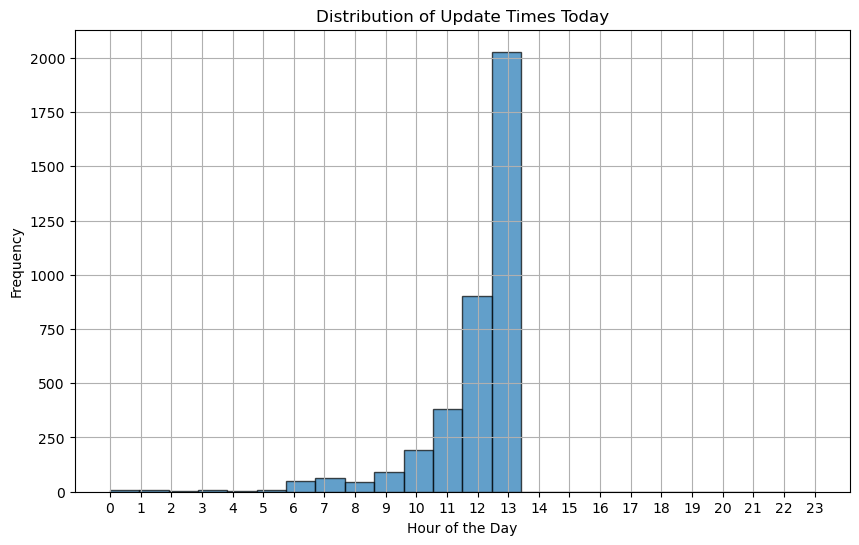

In [28]:
if todays_data.empty:
    print("No data available for today. Cannot perform update time analysis.")
else:
    # Extract the hour from the 'status_timestamp' and create a new column 'update_hour'
    todays_data['update_hour'] = todays_data['status_timestamp'].dt.hour

    # Create a frequency table for the update times
    frequency_table = todays_data['update_hour'].value_counts().sort_index()
    print("Frequency table for update times:")
    print(frequency_table)

    # If there are no update hours, inform the user
    if frequency_table.empty:
        print("No updates have been recorded today.")
    else:
        # Plot a histogram for the update times
        plt.figure(figsize = (10, 6))
        plt.hist(todays_data['update_hour'], bins = 24, range = (0, 23), edgecolor = 'black', alpha = 0.7)
        plt.xticks(range(24))
        plt.xlabel('Hour of the Day')
        plt.ylabel('Frequency')
        plt.title('Distribution of Update Times Today')
        plt.grid(True)
        plt.show()

Split into vacant and occupied status to visualize time distribution

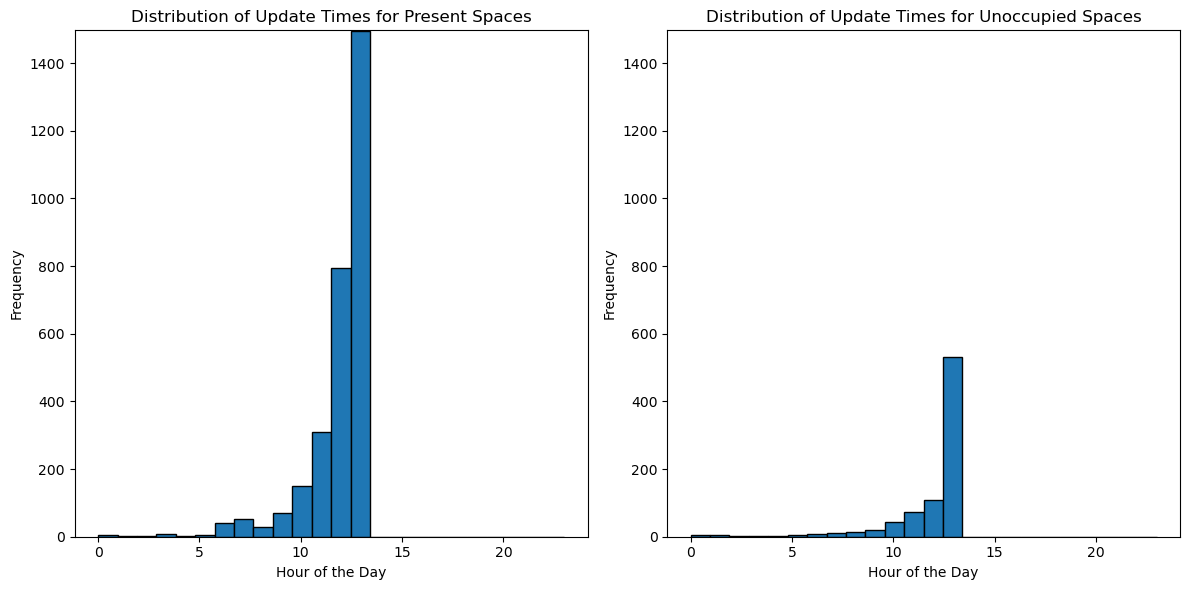

In [29]:
# ensure 'todays_data' contains data
if todays_data.empty:
    print("No data available for today. Cannot perform update time analysis.")
else:
    # Filter data for 'Present' and 'Unoccupied' states
    present_data = todays_data[todays_data['status_description'] == 'Present']
    unoccupied_data = todays_data[todays_data['status_description'] == 'Unoccupied']

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize = (12, 6))

    # Find the maximum frequency to set the same y-axis limit for both subplots
    # Check if either DataFrame is empty to avoid NaN in max_frequency
    max_freq_present = present_data['update_hour'].value_counts().max() if not present_data.empty else 0
    max_freq_unoccupied = unoccupied_data['update_hour'].value_counts().max() if not unoccupied_data.empty else 0
    max_frequency = max(max_freq_present, max_freq_unoccupied)

    # Plot histogram for 'Present' state if data is available
    if not present_data.empty:
        axes[0].hist(present_data['update_hour'], bins = 24, edgecolor = 'black', range = (0, 23))
        axes[0].set_title('Distribution of Update Times for Present Spaces')
        axes[0].set_xlabel('Hour of the Day')
        axes[0].set_ylabel('Frequency')
        axes[0].set_ylim([0, max_frequency + 1])  # +1 to ensure visibility if max_frequency is 0
    else:
        axes[0].text(0.5, 0.5, 'No data for Present Spaces', horizontalalignment = 'center', verticalalignment = 'center')
        axes[0].set_title('Distribution of Update Times for Present Spaces')
        axes[0].set_xlabel('Hour of the Day')
        axes[0].set_ylabel('Frequency')

    # Plot histogram for 'Unoccupied' state if data is available
    if not unoccupied_data.empty:
        axes[1].hist(unoccupied_data['update_hour'], bins = 24, edgecolor = 'black', range = (0, 23))
        axes[1].set_title('Distribution of Update Times for Unoccupied Spaces')
        axes[1].set_xlabel('Hour of the Day')
        axes[1].set_ylabel('Frequency')
        axes[1].set_ylim([0, max_frequency + 1])  # +1 to ensure visibility if max_frequency is 0
    else:
        axes[1].text(0.5, 0.5, 'No data for Unoccupied Spaces', horizontalalignment = 'center', verticalalignment = 'center')
        axes[1].set_title('Distribution of Update Times for Unoccupied Spaces')
        axes[1].set_xlabel('Hour of the Day')
        axes[1].set_ylabel('Frequency')

    # Show the plots
    plt.tight_layout()
    plt.show()

# Find parking restrictions

A parking space consists of three parts: parking space, parking space description, and sensors. Different departments manage the three and need to call different data sets. By comparing the parking space sensor and the bay's geographical location, the bayid of each geographical location is obtained. Then, get the description of the parking space through bayid.

## Get the kerbside id of the parking space

Fetch the whole dataset from City of Melbourne Open Portal.

In [30]:
# export endpoint

# https://data.melbourne.vic.gov.au/explore/dataset/on-street-parking-bays/table/
dataset2_id = 'on-street-parking-bays'

base_URL = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
# apikey = api_key
dataset2_id = dataset2_id
format = 'csv'

url = f'{base_URL}{dataset2_id}/exports/{format}'
params = {
    'select': '*',
    'limit': -1,  # all records
    'lang': 'en',
    'timezone': 'UTC',
    # 'api_key': apikey
}

# GET request
response = requests.get(url, params = params)

if response.status_code == 200:
    # StringIO to read the CSV data
    url_content = response.content.decode('utf-8')
    bay_df = pd.read_csv(StringIO(url_content), delimiter = ';')
    print(bay_df.sample(2, random_state = 999))    # test
else:
    print(f'Request failed with status code {response.status_code}')

      roadsegmentid kerbsideid  \
153           20939      24048   
9672          22511        NaN   

                                 roadsegmentdescription   latitude  \
153   Cobden Street between Princess Street and Quee... -37.804814   
9672  Garton Street between MacPherson Street and Bo... -37.783236   

       longitude lastupdated  
153   144.957268  2023-05-28  
9672  144.963804  2022-08-31  


In [31]:
# check length in dataset
print(f'The dataset contains {len(bay_df)} records.')

The dataset contains 19162 records.


Integrate and add road segment id and description to parking sensor dataframe

In [32]:
exclude = ['latitude', 'longitude', 'lastupdated']
bay_selected = bay_df.drop(exclude, axis = 1)

In [33]:
# filtered records to include non-numeric values only
filtered_bay = bay_selected[bay_selected['kerbsideid'].str.isnumeric() != False].copy()

filtered_bay['kerbsideid'] = pd.to_numeric(
    filtered_bay['kerbsideid'], errors = 'coerce').astype('Int64')

In [34]:
# Perform a left merge
merged_df = pd.merge(df_analysis, filtered_bay, on = ['kerbsideid'], how = 'left')
print(merged_df.head(2))

          lastupdated          status_timestamp  zone_number  \
0 2023-12-14 04:45:34 2023-12-14 14:41:25+11:00       7695.0   
1 2023-12-14 04:45:34 2023-12-13 17:21:58+11:00       7939.0   

  status_description  kerbsideid   latitude   longitude status_date  \
0         Unoccupied       22959 -37.818448  144.959387  2023-12-14   
1         Unoccupied       10136 -37.809991  144.952638  2023-12-13   

   roadsegmentid                             roadsegmentdescription  
0        20181.0  William Street between Flinders Lane and Colli...  
1        21518.0  King Street between Batman Street and Dudley S...  


In [35]:
merged_df.shape

(6158, 10)

In [36]:
# Check duplicated rows based on specific columns
kerb_dup = merged_df.duplicated(subset = ['kerbsideid'], keep = False)

# Display the duplicated rows based on 'kerbsideid'
merged_df[kerb_dup]

lastupdated          status_timestamp  zone_number  \
426  2023-12-05 00:44:41 2023-12-05 09:15:56+11:00       7644.0   
427  2023-12-05 00:44:41 2023-12-05 09:15:56+11:00       7644.0   
428  2023-12-05 00:44:41 2023-10-11 20:27:19+11:00       7333.0   
429  2023-12-05 00:44:41 2023-10-11 20:27:19+11:00       7333.0   
433  2023-12-05 00:44:41 2023-12-04 05:16:37+11:00       7333.0   
434  2023-12-05 00:44:41 2023-12-04 05:16:37+11:00       7333.0   
4419 2024-05-11 04:00:28 2024-05-11 13:52:09+10:00       7269.0   
4420 2024-05-11 04:00:28 2024-05-11 13:52:09+10:00       7269.0   

     status_description  kerbsideid   latitude   longitude status_date  \
426             Present       18002 -37.817446  144.953536  2023-12-05   
427             Present       18002 -37.817446  144.953536  2023-12-05   
428             Present       17806 -37.815782  144.961823  2023-10-11   
429             Present       17806 -37.815782  144.961823  2023-10-11   
433             Present       17807 -37.815764  144.961886  2023-12-04   
434             Present       17807 -37.815764  144.961886  2023-12-04   
4419            Present       24986 -37.811248  144.975538  2024-05-11   
4420            Present       24986 -37.811248  144.975538  2024-05-11   

      roadsegmentid                             roadsegmentdescription  
426         20073.0  Spencer Street between Little Collins Street a...  
427         20073.0  Spencer Street between Little Collins Street a...  
428         20099.0  Little Collins Street between Elizabeth Street...  
429         20099.0  Little Collins Street between Elizabeth Street...  
433         20099.0  Little Collins Street between Elizabeth Street...  
434         20099.0  Little Collins Street between Elizabeth Street...  
4419        20073.0  Spencer Street between Little Collins Street a...  
4420        21852.0  Parliament Place between St Andrews Place and ...

In [37]:
# Drop duplicated rows based on 'kerbsideid'
merged_df = merged_df.drop_duplicates(subset=['kerbsideid'], keep='first')
print(merged_df.shape)

(6154, 10)


Find out how many empty kerbsideid there are in total.

In [38]:
# Count the number of NaN values in the 'kerbsideid' column
num_nan = merged_df['kerbsideid'].isna().sum()

print(f"There are {num_nan} NaN values in the 'kerbsideid' column.")

There are 0 NaN values in the 'kerbsideid' column.


Find out how many empty kerbsideid there are in today’s data

In [39]:
# Filter to only include today's data
todays_data = merged_df[merged_df['status_date'] == today_melbourne]

# Count the number of NaN values in the 'kerbsideid' column for today's data
num_nan_today = todays_data['kerbsideid'].isna().sum()

print(f"There are {num_nan_today} NaN values in the 'kerbsideid' column for today's data.")

There are 0 NaN values in the 'kerbsideid' column for today's data.


## Get parking space description

In [40]:
# export endpoint

# https://data.melbourne.vic.gov.au/explore/dataset/on-street-car-park-bay-restrictions/table/
dataset3_id = 'on-street-car-park-bay-restrictions'

base_URL = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
# apikey = api_key
dataset3_id = dataset3_id
format = 'csv'

url = f'{base_URL}{dataset3_id}/exports/{format}'
params = {
    'select': '*',
    'limit': -1,  # all records
    'lang': 'en',
    'timezone': 'UTC',
    # 'api_key': apikey
}

# GET request
response = requests.get(url, params = params)

if response.status_code == 200:
    # StringIO to read the CSV data
    url_content = response.content.decode('utf-8')
    restrictions = pd.read_csv(StringIO(url_content), delimiter = ';')
    print(restrictions.sample(2, random_state = 999))    # test
else:
    print(f'Request failed with status code {response.status_code}')

      bayid  deviceid             description1            description2  \
540    1240     26566   1P MTR M-F 10:00-16:00  2P MTR M-F 19:00-20:30   
2353   8996     29953  2P MTR M-SAT 7:30-18:30       2P SUN 7:30-18:30   

                description3                description4 description5  \
540   1P MTR SAT 7.30-6.30PM  2P MTR SAT 6.30PM - 8.30PM          NaN   
2353                     NaN                         NaN          NaN   

     description6  disabilityext1  disabilityext2  ...  today3  today4  \
540           NaN             120           240.0  ...     6.0     6.0   
2353          NaN             240           240.0  ...     NaN     NaN   

      today5  today6  typedesc1  typedesc2  typedesc3  typedesc4  typedesc5  \
540      NaN     NaN   1P Meter   2P Meter   1P Meter   2P Meter        NaN   
2353     NaN     NaN   2P Meter         2P        NaN        NaN        NaN   

      typedesc6  
540         NaN  
2353        NaN  

[2 rows x 62 columns]


In [41]:
# check length in dataset 3

print(f'The dataset contains {len(restrictions)} records.')

The dataset contains 4263 records.


Get the columns description1-5 about the parking space restriction description. After online inspection on On-street Car Park Bay Restrictions, although description6 is marked as a time limit description, it is actually marked as January 1, AD1. There is no data description at the same time, so it is excluded manually.

In [42]:
# rename the 'bayid' column as'kerbsideid'
restrictions.rename(columns = {'bayid': 'kerbsideid'}, inplace = True)

In [43]:
# Merge merged_df with only the relevant columns from restrictions
columns_to_merge = ['kerbsideid', 'description1', 'description2',
                    'description3', 'description4', 'description5']
merged_df = pd.merge(
    merged_df,
    restrictions[columns_to_merge],
    left_on = 'kerbsideid',
    right_on = 'kerbsideid',
    how = 'left')

In [44]:
print(merged_df.head(2))

          lastupdated          status_timestamp  zone_number  \
0 2023-12-14 04:45:34 2023-12-14 14:41:25+11:00       7695.0   
1 2023-12-14 04:45:34 2023-12-13 17:21:58+11:00       7939.0   

  status_description  kerbsideid   latitude   longitude status_date  \
0         Unoccupied       22959 -37.818448  144.959387  2023-12-14   
1         Unoccupied       10136 -37.809991  144.952638  2023-12-13   

   roadsegmentid                             roadsegmentdescription  \
0        20181.0  William Street between Flinders Lane and Colli...   
1        21518.0  King Street between Batman Street and Dudley S...   

  description1 description2 description3 description4 description5  
0          NaN          NaN          NaN          NaN          NaN  
1          NaN          NaN          NaN          NaN          NaN  


Add time limits to each parking space

In [45]:
# Columns to check for "DIS"
columns_to_check = ['description1', 'description2', 'description3', 'description4', 'description5']

# Find rows where any of the specified columns contain "DIS"
contains_dis = merged_df[columns_to_check].apply(lambda x: x.str.contains('DIS')).any(axis = 1)

# Extract rows with "DIS" into a separate DataFrame
disabled_parking_df = merged_df[contains_dis]

# Delete rows with "DIS" from the original DataFrame
merged_df = merged_df[~contains_dis]

# Display the new DataFrames
print("Disabled Parking Data:")
print(disabled_parking_df.head())

print("Remaining Data:")
print(merged_df.head())

Disabled Parking Data:
            lastupdated          status_timestamp  zone_number  \
84  2023-10-25 01:44:02 2023-10-25 12:40:25+11:00       7572.0   
85  2023-10-25 01:44:02 2023-10-25 12:31:37+11:00       7572.0   
110 2023-11-22 00:44:42 2023-11-22 11:07:08+11:00          NaN   
183 2023-10-25 01:44:02 2023-10-25 12:03:28+11:00       7572.0   
187 2023-10-25 01:44:02 2023-10-25 12:23:52+11:00       7572.0   

    status_description  kerbsideid   latitude   longitude status_date  \
84          Unoccupied        6080 -37.809599  144.971422  2023-10-25   
85          Unoccupied        6086 -37.809544  144.971611  2023-10-25   
110            Present        6237 -37.817866  144.958069  2023-11-22   
183            Present        6081 -37.809592  144.971447  2023-10-25   
187            Present        6087 -37.809536  144.971637  2023-10-25   

     roadsegmentid                             roadsegmentdescription  \
84         20001.0  Lonsdale Street between Spring Street and Exhi..

Time limit to check how many parking spaces are empty.

In [46]:
# Columns to check for NaN values
columns_to_check = ['description1', 'description2', 'description3', 'description4', 'description5']

# Find rows where all specified columns are NaN
all_nan_rows = merged_df[columns_to_check].isna().all(axis = 1)

# Count the number of such rows
num_all_nan_rows = all_nan_rows.sum()

# Display the count
print(f"Number of rows where all of the specified columns are NaN: {num_all_nan_rows}")

Number of rows where all of the specified columns are NaN: 5481


## Conclusion

* We have integrated bay_id and parking space restrictions for each parking space. The existence number is unchanged.

* Through inspection, it can be found that the time limits of the parking spaces where most parking space sensors are located have not been integrated into the database. The lack of parking spaces is inconsistent with the reality.

* Three different systems or departments provide the three databases of parking space sensors, parking spaces, and parking restrictions. Missing data can be encountered. We will assume parking time restrictions.

# Today's parking space analysis

Due to the no parking space time limit, we will assume that the parking space time limit is 2 hours. The average parking time is 1 hour. Because the parking space sensor provides a snapshot, the sensor only records the most recent state. Pushing the collected empty parking spaces forward one hour is the assumed parking start time. Can analyze the theoretical last parking peak period.

## Time processing

In [47]:
# Step 1: Create a copy of today's data
todays_data_copy = todays_data.copy()

# Step 2: Filter to only include rows where the parking space is vacant
vacant_indices = todays_data_copy[todays_data_copy['status_description'] == 'Unoccupied'].index

# Step 3: Subtract 60 minutes from the timestamp of these vacant spaces
todays_data_copy.loc[vacant_indices, 'status_timestamp'] = todays_data_copy.loc[
    vacant_indices, 'status_timestamp'] - Minute(60)

# Step 4: Update the 'status_date' column based on the new 'status_timestamp'
todays_data_copy['status_date'] = todays_data_copy['status_timestamp'].dt.date

# Step 4: Change the status of these advanced-time vacant spaces to 'Occupied'
todays_data_copy.loc[vacant_indices, 'status_description'] = 'Occupied'

# Step 5: Remove rows where the 'status_date' is not today
todays_data_copy = todays_data_copy[todays_data_copy['status_date'] == today_melbourne]

## Popular parking hours

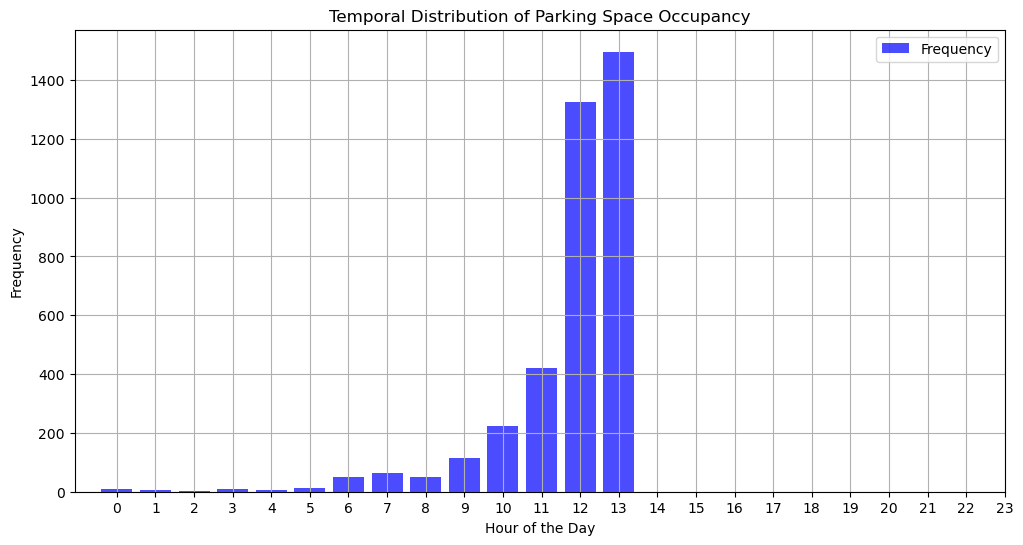

In [48]:
# Convert 'status_timestamp' to just the hour of the day
todays_data_copy['status_hour'] = todays_data_copy['status_timestamp'].dt.hour

# Create a frequency table for the update times
frequency_table = todays_data_copy['status_hour'].value_counts().sort_index()

# Plot a histogram for the update times
plt.figure(figsize = (12, 6))
plt.bar(frequency_table.index, frequency_table.values, color = 'blue', alpha = 0.7, label = 'Frequency')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.title('Temporal Distribution of Parking Space Occupancy')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend()
plt.show()

If time is even, it can be considered that the parking peak is still in progress. If it has started to decline, it can be considered that the previous peak has passed.

## Parking hotspot visualization

Today's parking spaces are clustered and marked on the map.

In [49]:
# Create a new DataFrame with only the latitude and longitude columns
X = todays_data_copy[['latitude', 'longitude']].values

# Run DBSCAN clustering
dbscan = DBSCAN(eps = 0.0005, min_samples = 20)
labels = dbscan.fit_predict(X)

# Add cluster labels back to DataFrame
todays_data_copy['cluster_label'] = labels

# Calculate the centroid of each cluster
cluster_centroids = todays_data_copy.groupby('cluster_label').agg(
    {'latitude': 'mean', 'longitude': 'mean'}).reset_index()

# Initialize the map
m = folium.Map(location = [-37.814, 144.963], zoom_start = 16)

# Add circles for each cluster
for idx, row in cluster_centroids.iterrows():
    if row['cluster_label'] != -1:  # -1 is the label for noise points in DBSCAN
        folium.Circle(
            location = [row['latitude'], row['longitude']],
            radius = 50,  # Radius
            color = 'blue',
            fill = True,
            fill_color = 'blue'
        ).add_to(m)

# Show the map
m

# Conclusion

Multiple analysis methods have been tried so far. Try combining multiple APIs. But, due to the lack of parking space time limits and the snapshot nature of the sensors. We can only analyze theoretical parking hotspots. There is a deviation from the actual situation. <br/>

If we need to analyze the possibility of a long time, we need to deploy the server in real time for a long time. It is difficult for ordinary readers to reproduce and operate. <br/>

This analysis is intended for data exploration. At the same time, it provides analysis reference for data that cannot be updated and integrated. Guide readers to realize the importance of data screening and processing. Presenting unprocessed data requires repeated analysis and screening. Provide a reference for data processing ideas.